#  Running AOS on AuxTel - main points

I find on which night defocal exposures were taken from the Observers Log, eg. https://confluence.lsstcorp.org/display/LSSTCOM/2021-06-08+Aux-Tel+Night+Log
    

Find dataset refs for these observations:

In [1]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/')
registry = butler.registry
datasetRefs = list(registry.queryDatasets(instrument='LATISS', datasetType='raw', collections=['LATISS/raw/all'],
                                          where="exposure.day_obs=20210608"
                                         ))
datasetRefs[0]

DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LATISS', detector: 0, exposure: 2021060800001, ...}, id=bfad0366-9915-5a37-b6f0-d42752929172, run='LATISS/raw/all')

I pick one intra - 2021060800400 and one extra - 2021060800401 exposure.

Show the raw exposures. Print `FOCUSZ` to show the offset:

In [4]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
exposure_intra = butler.get('raw', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021060800400},
                      collections=['LATISS/raw/all'])
print(exposure_intra.getMetadata()['FOCUSZ'])

exposure_extra = butler.get('raw', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021060800401},
                      collections=['LATISS/raw/all'])

print(exposure_extra.getMetadata()['FOCUSZ'])



/lsstdata/offline/instrument/LATISS/storage/2021-06-08/AT_O_20210608_000400-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


-0.770438730716705


/lsstdata/offline/instrument/LATISS/storage/2021-06-08/AT_O_20210608_000401-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


0.829561293125153


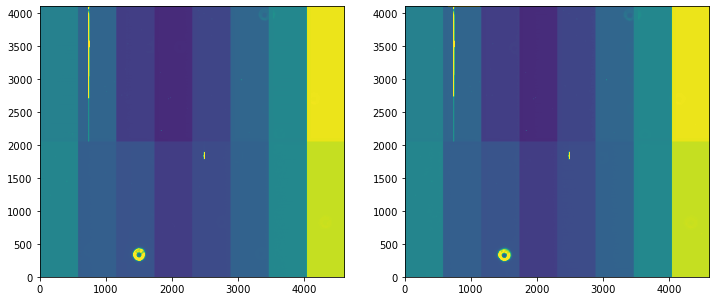

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax  = plt.subplots(1,2,figsize=(12, 10))
ax[0].imshow(exposure_extra.image.array, origin='lower',vmax=20000)# vmax=50)
mappable = ax[1].imshow(exposure_intra.image.array, origin='lower',vmax=20000)
#plt.colorbar(mappable,ax=ax[1])

Run the ISR : 

    pipetask run  --data-query "exposure IN (2021060800400,2021060800401) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISR11 --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types

Where the config yaml contained 

    isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: false
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doNanMasking: false
          doOverscan: true
          doVariance: false
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'

Show the postISR : 

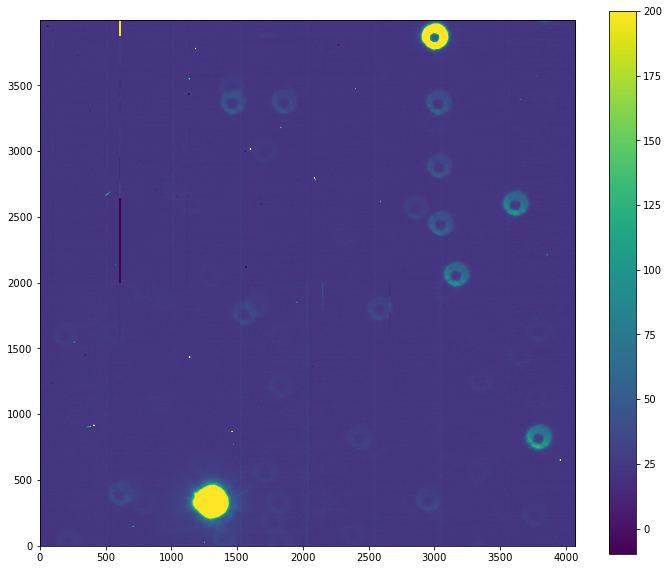

In [14]:
%matplotlib inline
from astropy.io import fits
hdula = fits.open('/repo/main/u/scichris/Latiss/postISR11/\
20210901T225749Z/postISRCCD/20210608/AT_O_20210608_000400/\
postISRCCD_LATISS_RG610~empty_AT_O_20210608_000400_RXX_S00_u_scichris_Latiss_postISR11_20210901T225749Z.fits'
                 )
fig = plt.figure(figsize=(12, 10))
plt.imshow(hdula[1].data, origin='lower',vmin=-10,vmax=200)
plt.colorbar()

### Create the donut catalog 

#### Set configurations for the task

Load the `ts_wep` modules

In [16]:
from lsst.ts.wep.task.GenerateDonutCatalogOnlineTask import (GenerateDonutCatalogOnlineTask, 
                                                             GenerateDonutCatalogOnlineTaskConfig)

Get the boresight and pointing angle from the raw exposure 

In [17]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/')
rawImage = butler.get('raw', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021060800400},
                      collections=['LATISS/raw/all'])

/lsstdata/offline/instrument/LATISS/storage/2021-06-08/AT_O_20210608_000400-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


In [18]:
rawImVisitInfo = rawImage.getInfo().getVisitInfo()
print(f"Boresight Ra, Dec is: {rawImVisitInfo.getBoresightRaDec()}, Boresight Rotation Angle in degrees is: {rawImVisitInfo.getBoresightRotAngle().asDegrees()}")

Boresight Ra, Dec is: (297.8343896415, -58.4925471458), Boresight Rotation Angle in degrees is: 25.7151863184216


Pass the boresight information to `ts_wep` : 

In [19]:
donutCatConfig = GenerateDonutCatalogOnlineTaskConfig()
donutCatConfig.boresightRa = rawImVisitInfo.getBoresightRaDec().getRa().asDegrees()
donutCatConfig.boresightDec = rawImVisitInfo.getBoresightRaDec().getDec().asDegrees()
donutCatConfig.boresightRotAng = rawImVisitInfo.getBoresightRotAngle().asDegrees()
donutCatConfig.filterName = 'phot_g_mean'

In [20]:
# instantiate the task with the appropriate config 
donutCatTask = GenerateDonutCatalogOnlineTask(config=donutCatConfig)

#### Prepare the data for the task

Need to get the reference catalog get available to `butler` repository: 

In [1]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
registry = butler.registry

deferredList = []
datasetGenerator = registry.queryDatasets(datasetType="gaia_dr2_20200414", 
                                          collections=["refcats"]).expanded()
for ref in datasetGenerator:
    deferredList.append(butler.getDeferred(ref, collections=["refcats"]))

KeyboardInterrupt: 

Change the mapping of the object loader and run the task to retrieve the reference object catalog:

In [ ]:
camera = "LATISS"
refObjLoader = donutCatTask.getRefObjLoader(deferredList)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }


donutCatStruct = donutCatTask.run(camera, deferredList)

We can get the donutCatalog out of it by specifying the property donutCatalog.

In [ ]:
donutCatalog = donutCatStruct.donutCatalog
donutCatalog.head()

I save it to avoid the lengthy query above next time 

In [ ]:
import pandas as pd
donutCatalog.to_csv('GAIA_donut_catalog.csv')

### Running the Zernike Estimation

In [2]:
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig()
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
estimateZernikeTask.instName = 'auxTel'
estimateZernikeTask.opticalModel = 'paraxial'

In [3]:
estimateZernikeTask.opticalModel

'paraxial'

Figure out what refs are available for the `postISR` image  from the butler :

In [4]:
from lsst.daf import butler as dafButler
instrument = 'LATISS'
dataId0 = dict(instrument=instrument)
repo_dir = '/repo/main/'
butler = dafButler.Butler(repo_dir, collections=['run1'])
                          
dataset = next(iter(
                butler.registry.queryDatasets(
                    datasetType='postISRCCD', 
                    collections=['u/scichris/Latiss/postISR11'],
                    dataId=dataId0  )
                )
           )

expN = dataset.dataId["exposure"]

# Get the refs  for this dataset
refs = []
for ref in butler.registry.queryDatasets(
                    datasetType='postISRCCD', 
                    collections=['u/scichris/Latiss/postISR11'],
                    dataId=dataId0  ):
    refs.append(ref)

In [5]:
refs[0].dataId

{instrument: 'LATISS', detector: 0, exposure: 2021060800401, ...}

Read in the two  postISR exposures - one is intra, the other extra-focal, but we don't need to know as the code will figure it out based on `FOCUSZ`:

In [6]:
exp1 = butler.get(datasetRefOrType='postISRCCD',dataId=refs[0].dataId,
              collections=['u/scichris/Latiss/postISR11'])

exp2 = butler.get(datasetRefOrType='postISRCCD',dataId=refs[1].dataId,
              collections=['u/scichris/Latiss/postISR11'])

# %matplotlib inline
# import matplotlib.pyplot as plt
# fig,ax = plt.subplots(1,2,figsize=(10,5))
# ax[0].imshow(exp1.image.array, origin='lower', vmin=-10,vmax=200)
# ax[1].imshow(exp2.image.array, origin='lower', vmin=-10,vmax=200)

Store as an exposure pair passed to `ts_wep` : 

In [7]:
expPair = [exp1,exp2]

### Run Task

Read the previously stored donut catalog:

In [8]:
import pandas as pd
donutCatalog = pd.read_csv('GAIA_donut_catalog.csv')

In [7]:
donutCatalog[:5]

,Unnamed: 0,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,detector
0,0,5.198804,-1.021757,653.219991,615.972550,50528.767694,RXX_S00
1,1,5.196814,-1.021203,3189.238069,720.084519,23607.292477,RXX_S00
2,2,5.198801,-1.021199,1177.698091,1698.170744,13863.613584,RXX_S00
3,3,5.197345,-1.020926,2910.604693,1517.382422,14370.503108,RXX_S00
4,4,5.198023,-1.021826,1380.952142,101.916337,20456.141629,RXX_S00


In [9]:
# This should return the extra-focal DonutStamps, intra-focal DonutStamps and
# Zernike coefficient numpy array as Struct that can be saved to
# Gen 3 repository all with the same dataId.
zernikeOutput = estimateZernikeTask.run(expPair, donutCatalog, "LATISS")

DonutTemplateModel, makeTemplate
DonutTemplateModel, makeTemplate
0 / 221
imageCoCenter: (x, y) = (   70.09,   78.19)

imageCoCenter: (x, y) = (   71.32,   78.85)

itr = 0, z4-z22
[ -5. -15. -16.  -1. -96.   9.   6.   1.   4.   2.   3.   4.  18.   0.
  -1.  -2.  -0.  -4.   0.]
itr = 1, z4-z22
[ -6. -11. -12.  -3. -98.   5.   4.   1.   4.   2.   3.   2.  19.   1.
  -1.  -1.   1.  -2.   0.]
itr = 2, z4-z22
[  -7.  -11.   -6.    0. -111.    3.   -3.    2.    3.    3.    2.    3.
   22.   -0.    1.   -1.    0.   -3.   -0.]
itr = 3, z4-z22
[  -8.  -14.  -12.   -6. -112.   -1.   -5.    2.    3.    2.    2.    3.
   22.    1.    1.    1.    1.   -2.   -0.]
itr = 4, z4-z22
[  -7.  -18.  -11.   -8. -116.   -3.   -9.    1.    2.    1.    1.    2.
   23.    2.    2.    1.    2.   -2.   -0.]
itr = 5, z4-z22
[ -5. -18. -10.  -3. -26.  -2. -10.   1.   3.   2.   1.   3.  -8.   0.
   1.   0.   1.  -2.  -0.]
itr = 6, z4-z22
[ -2. -13.  -0.  -4. -60.  -3. -13.   1.   3.   2.   1.   2.   4.   1.
   1.   

itr = 9, z4-z22
[ -35.   20. -238.  -21.  127.    8.  329.  -23.  -49.  -11.  -51.  -13.
   31.    4.   30.    5.   45.   21.   -0.]
itr = 10, z4-z22
[ -58.    7. -288.  -14.  119.   11.  373.  -27.  -59.  -10.  -62.  -19.
   45.    2.   33.    5.   50.   25.   -1.]
itr = 11, z4-z22
[ -79.  -12. -317.  -12.  151.   18.  402.  -31.  -67.   -9.  -71.  -25.
   45.    2.   39.    6.   60.   32.   -1.]
itr = 12, z4-z22
[ -95.  -19. -345.  -12.  160.   24.  434.  -32.  -71.  -10.  -76.  -29.
   54.    3.   44.    7.   67.   37.   -2.]
itr = 13, z4-z22
[-114.  -23. -363.  -10.  180.   28.  459.  -34.  -76.  -11.  -78.  -31.
   59.    3.   49.    7.   72.   41.   -2.]
itr = 14, z4-z22
[-132.  -33. -378.  -10.  201.   33.  483.  -35.  -79.  -11.  -77.  -31.
   64.    3.   54.    8.   77.   44.   -2.]
5 / 221
imageCoCenter: (x, y) = (   78.41,   78.69)

imageCoCenter: (x, y) = (   80.35,   79.72)

itr = 0, z4-z22
[ 1.  8. 32. -6. 28.  1.  3. -1. -6. -2. -3.  2. -7.  2. -1. -1.  0.  1.
 -0.]
itr 

itr = 3, z4-z22
[-28. -97. 113. -63. -53.  15.  11.   1. -11.  10.   3.   5.  12.  14.
  -2.  -4.  -0.   1.   1.]
itr = 4, z4-z22
[ -29. -128.  155.  -59.  -47.   19.   11.    0.  -10.   10.    3.    5.
   10.   14.   -2.   -5.   -0.    1.    1.]
itr = 5, z4-z22
[ -32. -131.  152.  -28.  -25.   23.   18.    1.   -9.   10.    4.    6.
    1.    0.   -2.   -3.   -1.    3.    0.]
itr = 6, z4-z22
[ -35. -125.  158.  -19.  -16.   34.   24.    1.  -10.    9.    2.    6.
   -1.   -1.   -2.   -4.   -1.    2.    0.]
itr = 7, z4-z22
[ -36. -131.  156.  -41.  -33.   39.   30.    1.   -9.   10.    4.    6.
    4.    5.   -2.   -3.   -1.    4.    0.]
itr = 8, z4-z22
[ -39. -125.  163.  -17.  -15.   50.   38.    2.   -9.    9.    2.    6.
   -2.   -2.   -2.   -4.   -1.    2.    0.]
itr = 9, z4-z22
[ -38. -127.  162.  -44.  -35.   41.   34.    1.   -9.    9.    5.   10.
    4.    5.   -2.   -3.   -2.    4.    0.]
itr = 10, z4-z22
[ -38. -131.  166.  -39.  -32.   38.   35.    1.   -9.   10.    8.   13

itr = 12, z4-z22
[  3. -31. -17.  -3.   5. -15.  16.   2.   0.   3.   1.  -0.  -1.   1.
  -1.   1.  -1.   2.  -1.]
itr = 13, z4-z22
[  2. -31. -18.   1.   4. -14.  16.   2.   0.   2.   1.  -1.  -1.  -0.
  -1.   1.  -1.   3.  -1.]
itr = 14, z4-z22
[  1. -31. -20.  -1.   4. -13.  17.   2.   0.   3.   1.  -1.  -1.   0.
  -1.   1.  -1.   3.  -1.]
14 / 221
imageCoCenter: (x, y) = (   79.37,   79.85)

imageCoCenter: (x, y) = (   68.50,  121.50)

itr = 0, z4-z22
[ -98.   79. -235.  124. -135.   80.  -80.   12.   66.  -20.    7.   -8.
   38.  -37.   29.  -33.    9.  -13.    9.]
itr = 1, z4-z22
[-190.  131. -231.  121. -127.   38.  -81.   39.   65.  -31.    0.  -24.
   37.  -46.   23.  -23.   14.  -12.    1.]
itr = 2, z4-z22
[-271.  124. -243.  149.  -89.   36.  -73.   37.   70.  -30.    5.  -26.
   25.  -55.   21.  -21.   15.   -9.    2.]
itr = 3, z4-z22
[-283.  254. -277.   -8.  256. -164.  131.    1.   26.  -53.   -2.   29.
  -60.   10.  -45.   52.   -6.   21.    8.]
itr = 4, z4-z22
[-388.  

itr = 2, z4-z22
[-1.  6.  6.  2.  3.  5.  3.  0. -1. -2.  4. -4. -1.  0. -0. -1. -0. -1.
 -0.]
itr = 3, z4-z22
[-1.  9. 10.  2.  3.  5.  3.  0. -1. -2.  4. -3. -1.  0. -0. -1.  0. -1.
 -0.]
itr = 4, z4-z22
[-1. 12. 13.  2.  3.  5.  3.  1. -1. -2.  4. -3. -1.  0. -0. -1.  0. -1.
 -0.]
itr = 5, z4-z22
[ 0.  9. 12.  1.  1.  6.  6.  1. -1. -1.  4. -3.  0.  0. -0. -1.  0. -0.
 -0.]
itr = 6, z4-z22
[ 2.  6. 12.  1.  1. 10.  7.  1. -1. -1.  4. -3.  0.  0. -0. -1. -0. -0.
 -0.]
itr = 7, z4-z22
[ 0.  0. 12. -3.  5. 16.  9.  2. -0. -1.  2. -2. -1.  1. -0. -2. -0. -1.
 -0.]
itr = 8, z4-z22
[ 0. -4. 14. -1.  3. 21. 10.  2.  0. -1.  2. -3.  0.  0. -0. -1. -0. -1.
 -0.]
itr = 9, z4-z22
[ 1. -6. 20. -1.  3. 21. 11.  2. -0. -1.  3. -4.  0.  0. -0. -1. -0. -2.
 -0.]
itr = 10, z4-z22
[ 4. -4. 22.  3.  0. 16. 13.  2. -2. -1.  6. -6.  0. -0. -0. -1.  0. -1.
 -1.]
itr = 11, z4-z22
[ 3. -6. 20.  1.  2. 16. 15.  2. -1. -1.  8. -8.  0.  0. -0. -1.  0. -2.
 -1.]
itr = 12, z4-z22
[  3.  -7.  19.   1.   2.  16. 

itr = 14, z4-z22
[-15.  -8.   8.  -1.  -2.   4.  18.   1.  -2.   1.  -4. -10.  -0.   1.
   0.  -1.  -0.   1.  -0.]
23 / 221
imageCoCenter: (x, y) = (   79.47,   79.75)

imageCoCenter: (x, y) = (   85.18,   75.41)

itr = 0, z4-z22
[  1. -57. -25. -45.  42.  -7.  -9.   0.   5.  11.   1.  -1.  -7.   9.
   2.   1.   2.   1.  -0.]
itr = 1, z4-z22
[  0. -58. -29. -45.  40.  -8. -11.   1.   6.  11.   1.  -2.  -7.   9.
   2.   1.   1.   1.  -1.]
itr = 2, z4-z22
[ -0. -55. -26. -48.  41.  -8. -12.   1.   6.  10.   0.  -2.  -7.   9.
   3.   1.   1.   1.  -1.]
itr = 3, z4-z22
[ -1. -84. -41. -51.  41.  -9. -14.   1.   5.   9.  -0.  -3.  -7.  10.
   3.   1.   1.   0.  -1.]
itr = 4, z4-z22
[  -2. -109.  -54.  -54.   41.   -9.  -15.    1.    5.    9.   -1.   -3.
   -7.   11.    3.    1.    1.   -0.   -1.]
itr = 5, z4-z22
[  -0. -107.  -51.  -12.   11.  -15.  -22.   -0.    5.    9.   -1.   -2.
    3.   -4.    3.    1.    1.    1.    0.]
itr = 6, z4-z22
[ -0. -99. -44. -28.  21. -20. -30.   0.   5.   

itr = 10, z4-z22
[-3. 16. -1.  4.  8.  9. -7.  1. -1. -0.  1.  3. -2. -0. -0. -0. -4. -1.
 -0.]
itr = 11, z4-z22
[-3. 19. -1.  3.  7.  9. -8.  1. -1. -0.  3.  3. -2.  0. -0.  0. -4. -1.
 -0.]
itr = 12, z4-z22
[ -5.  19.  -3.   4.   9.  10. -10.   1.  -1.  -0.   3.   4.  -2.  -0.
  -0.  -0.  -6.  -1.  -0.]
itr = 13, z4-z22
[ -6.  20.  -4.   4.   9.  11. -11.   1.  -1.  -0.   3.   4.  -2.  -0.
  -0.  -0.  -7.  -2.  -0.]
itr = 14, z4-z22
[ -7.  22.  -6.   4.   8.  12. -12.   1.  -1.  -0.   4.   5.  -2.  -0.
  -0.  -0.  -8.  -2.  -0.]
28 / 221
imageCoCenter: (x, y) = (   79.54,   79.80)

imageCoCenter: (x, y) = (   79.15,   79.43)

itr = 0, z4-z22
[-0.  5. 22. -0. -3.  1. -2.  1. -4. -1. -1.  2.  0.  0.  1.  0.  1.  2.
 -0.]
itr = 1, z4-z22
[-0.  5. 22. -0. -3.  1. -2.  1. -5. -1. -1.  2.  0.  0.  1.  0.  1.  2.
 -0.]
itr = 2, z4-z22
[ 1.  5. 18.  2.  4.  3. -4. -0. -4. -1. -1.  1. -1.  0.  1. -0.  2.  2.
 -0.]
itr = 3, z4-z22
[ 1.  8. 31.  1. -3. -1. -2.  0. -5. -1. -1.  2.  0. -0.  1.  0

itr = 9, z4-z22
[  7. -12. -15.   1.  -3.  12.   3.  -0.  -0.   0.   3.   0.   1.   0.
   0.  -1.  -0.   0.  -0.]
itr = 10, z4-z22
[  5. -13. -18.   1.  -3.  11.   4.  -0.  -0.   0.   4.   1.   1.   0.
   0.  -1.  -0.   0.  -0.]
itr = 11, z4-z22
[  4. -15. -20.   1.  -3.  10.   5.  -0.  -0.   0.   5.   1.   1.   0.
   0.  -1.  -1.   0.  -0.]
itr = 12, z4-z22
[  2. -18. -22.   1.  -3.   9.   6.   1.  -0.   0.   6.   1.   1.   0.
   0.  -1.  -1.   2.  -0.]
itr = 13, z4-z22
[  1. -17. -22.   2.  -3.   9.   8.   0.  -0.   0.   7.   1.   1.   0.
   0.  -1.  -1.   2.  -0.]
itr = 14, z4-z22
[ -1. -21. -24.   1.  -3.   8.   9.   1.  -0.   0.   8.   1.   1.   0.
   0.  -1.  -2.   3.  -1.]
33 / 221
imageCoCenter: (x, y) = (   97.96,   77.07)

imageCoCenter: (x, y) = (   79.68,   80.93)

itr = 0, z4-z22
[  2.   3.   9.  21. -11.  -0.  -4.  -1.  -2.  -1.  -2.  -1.   2.  -4.
   1.   0.  -1.   0.   0.]
itr = 1, z4-z22
[  2.   1.   9.  21. -13.  -0.  -5.  -1.  -2.  -1.  -2.  -1.   3.  -4.
   1.   0. 

itr = 4, z4-z22
[ -5. -20. -34.   2.  17.  -9.   1.   1.   4.   1.   3.   1.  -4.  -0.
  -1.   2.  -1.   1.  -0.]
itr = 5, z4-z22
[ -5. -16. -21.  -3.  -1. -13.  -5.   3.   3.   1.   4.   2.   3.   1.
   1.   2.  -1.   1.  -1.]
itr = 6, z4-z22
[ -1. -22. -21.   3.  13. -19.  -2.   3.   4.   1.   4.   1.  -2.  -1.
  -1.   2.  -1.   1.  -1.]
itr = 7, z4-z22
[  2. -15. -12.  -2.   0. -21.  -9.   3.   3.   0.   2.   1.   2.   1.
   1.   1.  -0.   1.  -1.]
itr = 8, z4-z22
[  7. -15.  -7.   1.   7. -24. -12.   3.   3.   1.   2.   1.   0.  -0.
   1.   1.  -0.   1.  -1.]
itr = 9, z4-z22
[  6. -13.  -3.  -0.   5. -23. -14.   4.   3.   0.   3.   1.   1.   0.
   1.   1.  -0.   1.  -1.]
itr = 10, z4-z22
[  6. -17.  -2.   3.   9. -23.  -8.   3.   4.   1.   5.   1.  -1.  -1.
  -1.   2.  -0.   2.  -1.]
itr = 11, z4-z22
[  6. -16.   5.   3.   9. -23. -10.   3.   4.   1.   6.   1.  -1.  -1.
  -1.   2.  -0.   2.  -1.]
itr = 12, z4-z22
[  6. -16.  11.   3.   9. -22. -12.   3.   4.   1.   7.   1.  -1.  -1

itr = 13, z4-z22
[ 10.  25. -24. -20.  -3.  26.  -9.   1.  -3.   1.  18.   3.   1.   2.
   2.  -2.  -7.   3.  -1.]
itr = 14, z4-z22
[ 10.  27. -28. -21.  -2.  26.  -7.   1.  -3.   1.  21.   3.   1.   3.
   2.  -2.  -8.   3.  -1.]
42 / 221
imageCoCenter: (x, y) = (   79.51,   79.68)

imageCoCenter: (x, y) = (   95.00,  115.00)

itr = 0, z4-z22
[-1. -1. -8. 11.  2. -4.  6. -1.  0.  1. -2. -0. -1. -2. -2.  1. -1.  0.
  0.]
itr = 1, z4-z22
[ 1. -4. -8. 11.  3. -3.  8. -1.  1.  2. -2. -0. -2. -2. -2.  1. -1.  0.
  0.]
itr = 2, z4-z22
[-1. -2. -8. 11.  2. -4.  7. -1.  0.  1. -2. -0. -1. -2. -2.  1. -1. -0.
  0.]
itr = 3, z4-z22
[ -2.  -2. -11.  11.   2.  -4.   7.  -1.  -0.   1.  -2.  -0.  -1.  -2.
  -2.   1.  -1.  -0.   0.]
itr = 4, z4-z22
[ -2.  -3. -17.  11.   2.  -3.   6.  -1.   0.   1.  -2.  -0.  -1.  -2.
  -2.   1.  -1.   0.   0.]
itr = 5, z4-z22
[ -4.   1. -19.   3.   1.  -5.  10.  -1.   0.   1.  -2.  -0.  -1.   1.
  -2.   1.  -1.   0.   0.]
itr = 6, z4-z22
[ -6.   4. -22.   5.   1.  -

itr = 0, z4-z22
[-1.  0. -5. 10. -7. -5.  0.  0.  1. -1. -1.  1.  3. -3.  0.  1.  0. -1.
 -0.]
itr = 1, z4-z22
[-1.  3. -6. 10. -7. -7. -1. -0.  1. -1.  0.  1.  2. -3.  0.  1.  1. -1.
 -0.]
itr = 2, z4-z22
[-1.  3. -6. 10. -6. -7. -1. -0.  1. -1.  0.  1.  2. -3.  0.  1.  0. -1.
 -0.]
itr = 3, z4-z22
[ -1.   2. -10.  11.  -6.  -5.  -1.  -0.   1.  -1.   0.   2.   2.  -3.
   1.   1.  -0.  -2.  -0.]
itr = 4, z4-z22
[ -2.   3. -13.  11.  -7.  -6.  -0.   0.   0.  -1.   0.   2.   2.  -3.
   0.   1.   1.  -1.  -0.]
itr = 5, z4-z22
[ -2.  -0. -14.   2.  -1. -10.  -1.   0.   0.  -1.   0.   2.   0.  -0.
   0.   1.   0.  -1.  -0.]
itr = 6, z4-z22
[ -3.  -4. -22.   5.  -4. -14.  -1.   0.   2.  -1.  -1.   2.   2.  -1.
   0.   2.   1.  -2.   0.]
itr = 7, z4-z22
[ -3.  -6. -22.   4.  -3. -17.  -2.   0.   1.  -1.  -1.   2.   1.  -1.
   0.   2.   1.  -2.   0.]
itr = 8, z4-z22
[ -3.  -8. -22.   5.  -3. -21.  -2.  -0.   1.  -0.  -1.   2.   1.  -1.
   0.   2.   1.  -2.   0.]
itr = 9, z4-z22
[ -3.  -9. -20.

itr = 14, z4-z22
[ -0.   8.  17.  -3.  -1. -18.   5.  -1.  -1.  -0.   7.  -0.   0.   1.
  -0.   1.   7.   4.   0.]
51 / 221
imageCoCenter: (x, y) = (   78.63,   79.40)

imageCoCenter: (x, y) = (   79.70,   80.08)

itr = 0, z4-z22
[ 0.  5.  5.  4. -1. -8. -3. -0.  0. -0.  3. -0.  1. -1.  0.  2. -0. -0.
  0.]
itr = 1, z4-z22
[ 1.  6.  6.  3. -1. -5.  1. -0. -0. -0.  0.  1.  1. -1. -1.  1. -1. -1.
 -0.]
itr = 2, z4-z22
[ 1.  5.  5.  4. -1. -8. -3. -0.  0. -0.  3. -0.  1. -1.  0.  2. -0. -0.
  0.]
itr = 3, z4-z22
[ 0.  9.  9.  4. -0. -6. -1.  0. -0. -1.  3. -1.  1. -1.  0.  1.  0. -0.
 -0.]
itr = 4, z4-z22
[ 1. 13. 13.  4. -2. -4. -0. -1. -1. -1. -0.  1.  1. -2. -1.  1. -0. -1.
 -0.]
itr = 5, z4-z22
[ 1. 12. 13.  1.  1. -3.  2. -0. -1. -1.  2. -2.  0. -0. -1.  1. -0. -0.
 -0.]
itr = 6, z4-z22
[ 1. 12. 11.  2. -1. -4.  4. -0. -1. -1.  2. -2.  1. -1. -1.  1. -0. -0.
 -0.]
itr = 7, z4-z22
[ 1. 12.  9.  2.  0. -5.  5. -0. -1. -1.  2. -2.  1. -1. -1.  1. -0. -0.
 -0.]
itr = 8, z4-z22
[ 2. 11.  

itr = 9, z4-z22
[ 11.  -2. -13.  -7.   1. -18. -29.  -0.  -1.   2.  -0.   3.   0.   1.
   2.   2.   2.   1.  -0.]
itr = 10, z4-z22
[ 10.  -1. -17.  -7.   0. -16. -28.  -0.  -1.   2.  -1.   3.   0.   1.
   2.   2.   3.   2.  -0.]
itr = 11, z4-z22
[  8.   4. -22.  -4.  -1. -14. -28.  -0.  -0.   1.  -2.   5.   1.   0.
   2.   2.   3.   3.  -0.]
itr = 12, z4-z22
[  7.   6. -26.  -4.   1. -11. -28.  -0.  -0.   1.  -3.   6.   0.   0.
   2.   1.   3.   4.  -0.]
itr = 13, z4-z22
[  7.   8. -25.  -6.  -0. -11. -27.  -0.  -1.   1.  -4.   7.   0.   1.
   2.   2.   3.   5.  -0.]
itr = 14, z4-z22
[  6.   9. -27.  -6.  -0.  -9. -28.  -0.  -1.   1.  -5.   8.   0.   1.
   2.   2.   4.   5.  -0.]
56 / 221
imageCoCenter: (x, y) = (   71.92,   78.47)

imageCoCenter: (x, y) = (   71.75,   79.51)

itr = 0, z4-z22
[ -4.  15.   1. -27.  -6.   3.   2.   1.   0.  -3.  -1.  -0.   1.   6.
  -1.   0.  -3.  -0.   0.]
itr = 1, z4-z22
[ -8.  16.   3. -27.  -5.   6.   2.   1.  -0.  -3.  -1.   0.   1.   6.
  -0.   0. 

itr = 4, z4-z22
[ -4. -27. -72.  17.  10.   3.  -1.   0.   6.   1.   2.   0.  -2.  -5.
   0.  -0.  -3.   1.  -0.]
itr = 5, z4-z22
[ -4. -29. -69.   5.   3.   4.  -1.   0.   6.   1.   2.   1.   0.  -0.
   0.  -0.  -3.   1.  -0.]
itr = 6, z4-z22
[ -4. -32. -67.   9.   6.   6.  -2.   1.   5.   1.   2.   1.  -1.  -2.
   0.  -0.  -3.   1.  -0.]
itr = 7, z4-z22
[ -4. -35. -65.   8.   5.   8.  -4.   1.   6.   1.   2.   0.  -0.  -1.
   0.  -1.  -3.   1.  -0.]
itr = 8, z4-z22
[ -2. -37. -61.   7.   4.   8.  -3.   0.   5.   1.   2.   1.  -0.  -1.
   0.  -0.  -4.   1.  -0.]
itr = 9, z4-z22
[ -2. -41. -59.  10.   5.   8.  -3.   0.   5.   1.   3.   2.  -1.  -2.
   0.  -0.  -6.   2.  -0.]
itr = 10, z4-z22
[ -3. -45. -58.  11.   5.   9.  -4.   1.   6.   1.   4.   2.  -1.  -3.
   0.  -0.  -7.   3.  -0.]
itr = 11, z4-z22
[ -4. -49. -55.  12.   6.   8.  -3.   1.   5.   1.   5.   3.  -1.  -3.
   0.  -0.  -9.   3.  -0.]
itr = 12, z4-z22
[ -5. -52. -53.  12.   5.   8.  -3.   1.   5.   1.   7.   3.  -1.  -3

itr = 14, z4-z22
[ 16.  11.   8.  30.  -3. -66.  13.  -2.   4.   0. -14.   5.   1.  -6.
  -1.   4.  -2.  -5.  -0.]
65 / 221
imageCoCenter: (x, y) = (   79.51,   79.51)

imageCoCenter: (x, y) = (   79.52,   79.51)

itr = 0, z4-z22
[ 1. -2. -7.  1.  8. -1.  4. -0.  1.  1.  2.  2. -2. -0. -2.  0. -1. -1.
 -0.]
itr = 1, z4-z22
[  1. -11. -11.  -3.  17.  11.  -1.  -0.   1.   2.  -2.   2.  -3.   1.
  -1.  -0.   1.   4.   0.]
itr = 2, z4-z22
[  1. -21. -23.  -8.  30.  39. -16.  -0.   3.   2. -11.   1.  -4.   1.
   1.  -5.   4.  13.   0.]
itr = 3, z4-z22
[ -5. -14. -58.  -3.  23.  20. -20.   0.   5.   0. -12.   6.  -3.   0.
   2.  -2.  -4.   8.   1.]
itr = 4, z4-z22
[ -3. -38. -76.  -6.  31.  38. -25.  -0.   4.   2. -18.  -1.  -3.   0.
   3.  -4.  -1.  12.   0.]
itr = 5, z4-z22
[ -4. -32. -68.  -0.   1.  48. -25.  -0.   2.   1.  -8.   2.   4.  -1.
  -0.  -2.   1.   9.   1.]
itr = 6, z4-z22
[  1. -37. -52.   2.   2.  46. -17.  -0.   1.   1.  -1.  -2.   1.  -1.
  -2.  -0.   2.   1.  -0.]
itr = 7

itr = 8, z4-z22
[  9.   5.   9.  -2.   2. -10.   3.  -2.  -2.  -0.  -2.  -1.   1.   0.
   1.   1.  -1.   3.   0.]
itr = 9, z4-z22
[ 9.  5.  7. -2.  2. -9.  5. -2. -2. -0. -3. -1.  0. -0.  1.  1. -2.  5.
  0.]
itr = 10, z4-z22
[ 9.  6.  5. -1.  3. -8.  6. -2. -2. -1. -4. -1. -0. -0.  0.  1. -2.  6.
  0.]
itr = 11, z4-z22
[11.  5.  4. -2. -0. -8.  7. -3. -2. -1. -5. -1.  1. -0.  1.  1. -2.  8.
  0.]
itr = 12, z4-z22
[10.  5.  0. -1.  4. -8. 10. -3. -2. -1. -7. -2. -0. -0.  0.  1. -3.  9.
  0.]
itr = 13, z4-z22
[11.  5. -3. -1.  4. -7. 12. -3. -2. -1. -8. -2. -0. -0.  0.  1. -4. 10.
  0.]
itr = 14, z4-z22
[ 10.   5.  -8.  -1.   7.  -3.  18.  -3.  -2.  -1. -11.  -3.  -1.  -0.
  -0.   0.  -4.  12.   0.]
70 / 221
imageCoCenter: (x, y) = (   79.59,   79.21)

imageCoCenter: (x, y) = (   79.60,   79.78)

itr = 0, z4-z22
[-3.  1.  2. -3.  1. -6. -7.  1.  0.  0. -0. -0. -0.  0.  2.  1.  2.  0.
 -0.]
itr = 1, z4-z22
[-5.  3. -0. -3.  1. -5. -8.  1.  0.  0. -1. -0. -0.  0.  2.  2.  2.  1.
 -0.]
itr

itr = 3, z4-z22
[ -11.  -52.   24.  -58. -138.   -4.  -16.    1.   -3.    6.    4.    2.
   31.   13.    3.    0.    1.   -2.    0.]
itr = 4, z4-z22
[ -15.  -79.   55.  -61. -131.   -1.  -18.    1.   -7.    7.    4.    4.
   29.   14.    4.   -1.    2.   -1.    0.]
itr = 5, z4-z22
[ -8. -55.  39. -10. -19.  -2. -29.   0.  -5.   4.   2.   1.  -8.  -3.
   4.   0.   1.   0.  -0.]
itr = 6, z4-z22
[ -7. -50.  36. -28. -61.  -1. -37.   0.  -5.   4.   2.   1.   8.   4.
   3.  -0.   1.   0.  -0.]
itr = 7, z4-z22
[ -4. -45.  40. -23. -47.   1. -46.  -1.  -6.   4.   2.   1.   3.   2.
   3.  -0.   1.   1.  -0.]
itr = 8, z4-z22
[ -6. -47.  37. -23. -49.   3. -54.   0.  -5.   5.   2.   2.   4.   3.
   3.  -1.   1.   1.  -0.]
itr = 9, z4-z22
[ -3. -36.  34. -32. -65.   0. -52.  -0.  -5.   4.   3.   2.   8.   5.
   3.  -1.   2.   1.  -0.]
itr = 10, z4-z22
[ -2. -32.  32. -33. -66.  -1. -51.  -1.  -5.   4.   4.   3.   9.   5.
   3.  -1.   2.   1.  -0.]
itr = 11, z4-z22
[ -1. -28.  29. -33. -66.  -2. -

itr = 0, z4-z22
[-104.   82. -247.  125. -135.   82.  -82.   13.   69.  -19.    1.   -7.
   37.  -37.   29.  -34.    9.  -14.   10.]
itr = 1, z4-z22
[-202.  133. -244.  121. -127.   44.  -81.   41.   67.  -30.   -2.  -22.
   36.  -45.   25.  -24.   16.  -11.    1.]
itr = 2, z4-z22
[-287.  135. -259.  149.  -93.   38.  -69.   40.   73.  -31.    2.  -24.
   26.  -55.   21.  -22.   15.   -8.    2.]
itr = 3, z4-z22
[-305.  272. -294.  -15.  269. -167.  137.    5.   29.  -55.   -7.   33.
  -63.   13.  -47.   53.   -5.   20.    7.]
itr = 4, z4-z22
[-401.  313. -526.  153. -233.  106. -130.   19.   76.  -22.   -1.  -13.
   64.  -45.   41.  -45.   21.  -18.   11.]
itr = 5, z4-z22
[-433.  283. -313.   30. -111.  161. -190.   15.   46.  -16.   -4.   -9.
   19.   -3.   35.  -43.   17.  -17.   13.]
itr = 6, z4-z22
[-469.  266. -311.   69.  -88.  221. -249.   12.   61.  -17.   14.   -5.
   13.  -11.   32.  -43.   24.  -14.   12.]
itr = 7, z4-z22
[-499.  258. -166.   -6. -134.  259. -270.   11.   37

itr = 7, z4-z22
[  2. -13.  -3.  -8.   2.  -0.  -1.   1.  -1.   0.  -0.  -1.  -0.   2.
  -0.   1.  -1.  -0.  -0.]
itr = 8, z4-z22
[  2. -10.  -2.   0.   1.   4.  -2.   2.  -2.  -1.  -2.  -0.   0.  -1.
   0.  -0.  -1.   1.  -0.]
itr = 9, z4-z22
[  3. -13.  -7.  -3.   3.   4.  -4.   1.  -2.  -0.  -5.   0.  -0.  -0.
   1.  -0.  -0.   1.  -0.]
itr = 10, z4-z22
[  3. -14. -13.  -4.   3.   5.  -3.   1.  -2.  -0.  -8.   1.   0.   0.
   1.  -0.   0.   1.  -0.]
itr = 11, z4-z22
[  2. -14. -14.  -3.  -0.   4.   2.   1.  -2.  -1.  -9.  -0.   1.  -0.
  -0.  -0.  -1.   1.  -0.]
itr = 12, z4-z22
[  3. -18. -24.  -4.   2.   7.  -4.   0.  -2.   0. -11.   1.   0.   1.
   2.  -0.  -1.   2.   0.]
itr = 13, z4-z22
[  3. -17. -28.  -5.   0.   7.   2.   1.  -2.  -1. -12.   1.   1.   1.
   0.  -0.  -1.   2.  -0.]
itr = 14, z4-z22
[  3. -21. -32.  -5.   1.   9.   2.   1.  -2.  -1. -13.   1.   0.   1.
   0.  -0.  -2.   3.  -0.]
84 / 221
imageCoCenter: (x, y) = (  130.00,   99.75)

imageCoCenter: (x, y) = (   7

itr = 2, z4-z22
[ 4. -1.  4.  0. 11.  6.  3. -0.  0. -1.  1. -0. -2. -0. -0. -2.  1. -1.
  0.]
itr = 3, z4-z22
[ 5. -2.  7.  0. 11.  6.  3. -0. -0. -1.  1. -0. -2. -0. -0. -2.  1. -1.
  0.]
itr = 4, z4-z22
[ 6. -1. 13.  0. 11.  4.  2. -0. -0. -1.  1.  0. -2. -0. -0. -1.  1. -1.
  0.]
itr = 5, z4-z22
[ 7. -5. 18.  0.  0.  6.  4. -1. -1. -1. -0. -1.  1. -0. -1. -1.  1. -1.
 -0.]
itr = 6, z4-z22
[  7. -12.  19.   0.   8.   9.   5.  -1.  -0.  -1.   1.   0.  -1.  -0.
  -0.  -1.   1.  -1.   0.]
itr = 7, z4-z22
[  8. -15.  24.   0.   1.  10.   8.  -1.  -1.  -1.  -0.  -0.   1.  -0.
  -1.  -1.   1.  -1.  -0.]
itr = 8, z4-z22
[  8. -19.  27.   0.   5.  12.  10.  -1.  -1.  -1.  -0.  -0.  -0.  -0.
  -1.  -1.   1.  -1.  -0.]
itr = 9, z4-z22
[  9. -23.  30.   0.   4.  11.   9.  -1.  -1.  -1.  -0.  -1.   0.  -0.
  -1.  -1.   2.  -1.  -0.]
itr = 10, z4-z22
[  9. -27.  33.   1.   5.   9.   9.  -1.  -1.  -1.   1.  -1.  -0.  -0.
  -0.  -1.   3.  -2.   0.]
itr = 11, z4-z22
[ 10. -29.  36.   1.   4.  11.  

itr = 11, z4-z22
[-15. -66.  11. -20.  -1.  60.  -1.   1.   0.   4.   4.  -3.  -1.   5.
   1.  -5.   4.   6.  -0.]
itr = 12, z4-z22
[-15. -67.  12. -19.  -1.  56.  -1.   1.   0.   4.   5.  -5.  -1.   5.
   1.  -5.   5.   7.  -0.]
itr = 13, z4-z22
[-14. -68.  14. -19.  -0.  52.   0.   2.   0.   4.   5.  -5.  -1.   5.
   1.  -5.   6.   8.  -0.]
itr = 14, z4-z22
[-15. -69.  17. -20.  -0.  47.   1.   2.  -0.   4.   6.  -6.  -1.   5.
   1.  -5.   7.   9.  -0.]
93 / 221
imageCoCenter: (x, y) = (   75.77,   81.06)

imageCoCenter: (x, y) = (   79.60,   80.35)

itr = 0, z4-z22
[  5.  -0.  -5.   3. -38.   1.  -6.  -2.  -0.  -0.   3.  -3.   8.  -1.
   2.  -0.  -0.  -1.   0.]
itr = 1, z4-z22
[  7.   1.  -2.   3. -38.  -1.  -5.  -2.  -1.  -0.   3.  -2.   8.  -1.
   2.  -0.  -1.  -2.   0.]
itr = 2, z4-z22
[ 11.   2.  -2.   4. -38.   0.  -7.  -2.  -1.  -0.   3.  -2.   8.  -1.
   2.  -0.  -0.  -1.   0.]
itr = 3, z4-z22
[ 14.   3.  -4.   4. -37.   1.  -7.  -2.  -1.  -0.   3.  -2.   8.  -1.
   2.  -0.  

itr = 7, z4-z22
[  1. -10.   9.  -3.   2.   2. -10.  -0.  -1.   0.  -1.  -1.  -0.   1.
   1.  -0.   1.  -0.  -0.]
itr = 8, z4-z22
[  4.  -7.   7.   2.   0.   6. -11.  -0.  -0.   1.   1.  -1.   0.  -1.
   1.  -0.   2.  -0.  -0.]
itr = 9, z4-z22
[  3.  -5.  10.  -0.  -0.   7. -12.  -0.  -1.   0.   1.  -2.   1.  -0.
   1.   0.   3.  -0.  -0.]
itr = 10, z4-z22
[ 3. -6. 12. -0.  0.  9. -9. -1. -0.  1.  1. -3.  1.  0.  1. -0.  4. -0.
 -0.]
itr = 11, z4-z22
[ -1.  -2.  14.  -3.   1.   9. -10.  -0.  -1.   0.  -2.  -4.   0.   1.
   1.  -0.   5.  -0.   0.]
itr = 12, z4-z22
[-2. -7. 13. -3.  1. 10. -8. -0. -1.  0. -2. -5.  0.  1.  1. -0.  6.  1.
  0.]
itr = 13, z4-z22
[-2. -9. 12. -3.  1. 10. -8. -0. -1.  0. -2. -5. -0.  1.  1. -0.  6.  2.
  0.]
itr = 14, z4-z22
[-1. -9. 12. -3.  2. 10. -8. -1. -1.  0. -5. -7. -0.  1.  1. -0.  8.  1.
  0.]
98 / 221
imageCoCenter: (x, y) = (   69.00,   67.14)

imageCoCenter: (x, y) = (  100.00,  140.50)

itr = 0, z4-z22
[ 119.  131. -137.  215.  117.   25.  -85.  

itr = 0, z4-z22
[-4.  6.  1.  2.  0.  0.  6.  1. -1. -1. -1.  1.  0. -0. -1. -0.  0. -0.
 -0.]
itr = 1, z4-z22
[-7.  7.  1.  2.  0.  0.  6.  1. -1. -1. -1.  1.  0. -0. -1. -0.  0. -0.
 -0.]
itr = 2, z4-z22
[-10.   7.   2.   2.   0.   0.   6.   1.  -1.  -1.  -1.   1.   0.  -0.
  -1.  -0.   0.  -0.  -0.]
itr = 3, z4-z22
[-13.  11.   3.   2.   0.   0.   6.   1.  -1.  -1.  -1.   1.   0.  -0.
  -1.  -0.   0.  -0.  -0.]
itr = 4, z4-z22
[-14.  12.   2.   5.  -1.  -1.   4.   1.  -1.  -1.  -2.  -1.   0.  -1.
  -1.   0.   1.  -0.   0.]
itr = 5, z4-z22
[-16.  11.  -3.   2.  -2.  -1.   5.   1.  -0.  -1.  -2.  -1.   0.   0.
  -1.   0.   1.  -1.  -0.]
itr = 6, z4-z22
[-15.   9.  -3.   2.   1.  -1.   8.   1.  -1.  -1.  -1.  -1.  -0.   0.
  -1.   0.   1.   0.  -0.]
itr = 7, z4-z22
[-16.   8.  -5.   3.  -0.  -2.  12.   1.  -1.  -1.  -1.  -0.   0.  -0.
  -1.   0.   1.   0.  -0.]
itr = 8, z4-z22
[-16.   7.  -9.   2.  -1.  -3.  15.   2.  -1.  -1.  -1.  -1.  -0.   0.
  -1.   0.   1.  -1.  -0.]
itr = 9, z4-

itr = 8, z4-z22
[ -3. -10.  22.   5.  -0. -12. -23.  -1.  -1.  -1.   1.   0.   0.   0.
   2.   1.   1.  -0.   0.]
itr = 9, z4-z22
[ -4. -13.  23.   5.  -0. -11. -22.  -1.  -1.  -1.   2.   1.   0.   0.
   2.   1.   1.  -1.   0.]
itr = 10, z4-z22
[ -4. -17.  24.   5.  -1. -11. -21.  -1.  -1.  -1.   2.   1.   0.   0.
   2.   1.   2.  -0.   0.]
itr = 11, z4-z22
[ -5. -20.  25.   5.  -1. -10. -19.  -1.  -1.  -1.   2.   1.   1.   0.
   2.   1.   2.  -0.   0.]
itr = 12, z4-z22
[ -5. -22.  26.   5.  -1. -10. -18.  -1.  -1.  -1.   3.   1.   1.   0.
   2.   1.   3.  -0.   0.]
itr = 13, z4-z22
[ -6. -25.  27.   5.  -1.  -9. -16.  -1.  -1.  -1.   3.   1.   1.   0.
   2.   1.   4.   0.   0.]
itr = 14, z4-z22
[ -7. -25.  30.   5.   0.  -7. -14.  -1.  -1.  -1.   4.   2.   0.   0.
   2.   1.   4.  -1.   0.]
106 / 221
imageCoCenter: (x, y) = (   68.94,   77.92)

imageCoCenter: (x, y) = (   72.73,   81.91)

itr = 0, z4-z22
[-3. 21. -6. 10.  1. 13. -7.  1.  5. -0.  3.  8.  2. -3.  2. -3.  3.  1.
  0.]
it

itr = 4, z4-z22
[ 8. 10.  0.  8.  2. -8.  5. -1.  0. -1. -1. -1. -0. -3. -1.  1. -0.  0.
  0.]
itr = 5, z4-z22
[  7.   7.   1.   3.   0. -13.   7.  -1.   0.  -0.  -2.  -1.   0.  -1.
  -1.   1.  -0.   0.   0.]
itr = 6, z4-z22
[  6.  11.   3.   4.   2. -18.  11.  -2.  -0.  -1.  -1.  -1.  -0.  -1.
  -1.   1.  -0.  -0.   0.]
itr = 7, z4-z22
[  5.  11.   1.   5.   1. -23.  15.  -2.  -0.  -0.  -1.  -1.  -0.  -1.
  -1.   1.  -1.   0.   0.]
itr = 8, z4-z22
[  3.  11.  -1.   4.   1. -27.  17.  -2.   1.  -0.  -2.  -0.  -0.  -1.
  -1.   1.  -0.  -0.   0.]
itr = 9, z4-z22
[  3.  13.   0.   6.   2. -30.  16.  -2.   1.  -0.  -3.  -0.  -1.  -1.
  -1.   1.  -0.  -1.   0.]
itr = 10, z4-z22
[  3.  15.   2.   6.   2. -32.  15.  -3.   1.  -0.  -3.  -1.  -1.  -2.
  -1.   1.  -1.  -1.   0.]
itr = 11, z4-z22
[  3.  16.   3.   7.   2. -35.  14.  -3.   1.  -0.  -4.  -1.  -1.  -2.
  -1.   1.  -1.  -1.   0.]
itr = 12, z4-z22
[  4.  15.   1.   6.   2. -30.  12.  -3.   1.   0.  -7.  -1.  -0.  -1.
  -1.  -0.   1.  

itr = 12, z4-z22
[-4. -3.  3. -2. -2.  0. -9.  0. -1.  2.  9.  4.  1.  1.  0.  1.  4. -4.
 -0.]
itr = 13, z4-z22
[ -3.  -1.   5.  -2.  -1.  -1. -13.   0.  -2.   1.  10.   4.   1.   0.
   1.   1.   4.  -4.  -0.]
itr = 14, z4-z22
[ -4.  -3.   3.  -0.  -2.  -0. -14.   0.  -1.   1.  11.   4.   1.  -0.
   1.   1.   4.  -4.  -0.]
115 / 221
imageCoCenter: (x, y) = (   79.33,   78.24)

imageCoCenter: (x, y) = (   79.94,   77.93)

itr = 0, z4-z22
[  2. -10. -10.  14.   1.  -2.   4.  -0.   1.   2.   1.   1.  -0.  -4.
  -1.   1.   1.   0.  -0.]
itr = 1, z4-z22
[  6. -14. -10.  11.   2.  -3.   4.  -1.   1.   2.   0.   2.  -0.  -3.
  -1.   1.   2.  -1.  -0.]
itr = 2, z4-z22
[  6. -11.  -5.  14.   0.  -3.   3.  -0.   1.   2.   1.   2.   0.  -3.
  -1.   1.   1.  -0.  -0.]
itr = 3, z4-z22
[  8. -16.  -9.  13.   1.  -1.   2.  -0.   1.   2.  -0.   2.  -0.  -3.
  -1.   0.   1.   1.  -0.]
itr = 4, z4-z22
[  9. -22. -13.  13.   1.  -1.   2.  -0.   1.   2.  -0.   2.  -0.  -3.
  -1.   0.   1.   1.  -0.]
itr 

itr = 5, z4-z22
[ -2. -14. -12.   0.   3.  -1.  -6.  -1.   2.   1.  -0.   1.   1.   1.
   1.  -0.   1.   1.   0.]
itr = 6, z4-z22
[ -3. -10.  -8.  -1.   9.   0.  -5.  -1.   2.  -0.  -1.   0.  -2.   1.
   0.   1.   2.   2.   0.]
itr = 7, z4-z22
[ -5. -11.   1.   1.   6.   1.  -6.  -0.   1.  -0.  -0.   1.  -1.   1.
   0.   1.   1.   2.   0.]
itr = 8, z4-z22
[ -5. -12.   5.  -0.   7.   1.  -7.  -0.   2.  -0.  -0.   1.  -1.   1.
   0.   1.   1.   2.   0.]
itr = 9, z4-z22
[ -5. -12.  10.  -2.   8.   4.  -6.  -0.   2.  -0.  -0.   2.  -1.   1.
   0.   1.   2.   4.   0.]
itr = 10, z4-z22
[ -6. -13.  10.  -1.   8.   5.  -6.  -0.   2.  -0.  -1.   3.  -2.   1.
   0.   1.   3.   6.   0.]
itr = 11, z4-z22
[ -5. -17.   9.  -1.   6.   7.  -8.  -0.   2.   0.  -3.   3.  -0.   1.
   1.   0.   3.   6.   0.]
itr = 12, z4-z22
[ -6. -17.  14.  -1.   6.   9.  -8.   0.   2.   0.  -4.   3.  -0.   1.
   1.   0.   4.   6.   0.]
itr = 13, z4-z22
[ -6. -11.  19.   0.   9.  10.  -6.   0.   1.  -1.  -3.   5.  -2.   

itr = 10, z4-z22
[ -536. -2389. -5165.  7653.  1070.  7160. -1765. -3105.  1423.  -272.
  -502.   379.  2331.  -499.  2798. -1094.   818.   166.   971.]
itr = 11, z4-z22
[ -473. -2953. -5947.  8263.  1089.  6767. -2232. -3280.  1628.  -216.
  -673.   220.  2251.  -627.  2904.  -923.   804.   -35.  1047.]
itr = 12, z4-z22
[ -230. -1152. -4069. 11775. -2676.  9164. -1390. -3488.   889.  -490.
 -1094.   404.  2919. -1218.  2679. -1664.   418.  -581.   987.]
itr = 13, z4-z22
[  2948.  -4527. -14451.    692.  18421.  -4582.  -4280.  -5336.   1562.
   -397.  -1628.  -4084.  -1497.   -786.   4251.   1421.   3919.   1722.
   1331.]
itr = 14, z4-z22
[ 1495. -3104. -9288.  4597.  9984.   481. -3053. -4344.  1116.  -424.
 -1422. -2304.   300.  -810.  3587.   299.  2471.  1008.  1124.]
124 / 221
imageCoCenter: (x, y) = (   79.47,   79.49)

imageCoCenter: (x, y) = (   79.49,   79.46)

itr = 0, z4-z22
[  5.   7.  12. -18.   8.  -7.  -7.  -1.  -1.  -1.   2.  -1.  -2.   5.
   2.   2.  -2.  -1.  -0.]
i

itr = 1, z4-z22
[ -6.   5.  -1. -12.   5.   3.   2.   0.   0.   0.   2.   0.  -2.   2.
  -0.  -1.   2.  -2.   0.]
itr = 2, z4-z22
[ -8.   7.  -2. -11.   5.   2.   2.   0.   0.  -0.   2.   1.  -2.   2.
  -0.  -1.   2.  -2.   0.]
itr = 3, z4-z22
[ -9.   8.  -1. -12.   6.   2.   1.   0.   0.  -0.   2.   1.  -2.   3.
   0.  -0.   2.  -1.   0.]
itr = 4, z4-z22
[-10.  13.   1. -12.   7.   1.   1.   0.   0.  -1.   2.   1.  -2.   2.
  -0.  -0.   2.  -1.   0.]
itr = 5, z4-z22
[-13.  14.  -1.  -3.   0.   4.   2.   1.   1.  -0.   3.   1.  -0.  -1.
  -0.  -1.   2.  -1.   0.]
itr = 6, z4-z22
[-13.  15.   3.  -5.   3.   4.   1.   1.   1.  -0.   2.   2.  -1.   0.
   0.  -0.   2.  -1.   0.]
itr = 7, z4-z22
[-14.  16.   5.  -5.   2.   5.   1.   1.   1.  -0.   2.   2.  -1.   0.
   0.  -0.   2.  -1.   0.]
itr = 8, z4-z22
[-14.  20.   9.  -5.   5.   6.   3.   1.   0.  -1.   2.   1.  -2.   0.
  -0.  -0.   2.  -1.   0.]
itr = 9, z4-z22
[-13.  20.   9.  -6.   5.   6.   2.   1.   0.  -0.   3.   2.  -2.   0.
 

itr = 7, z4-z22
[ -0.  25.  15.  16.   3. -20. -18.   0.   1.  -3.   1.   0.  -0.  -0.
   1.  -0.  -2.   3.  -0.]
itr = 8, z4-z22
[  1.  23.  18.  17.   3. -24. -22.   1.   1.  -3.   1.   0.  -0.  -0.
   1.  -0.  -2.   3.  -0.]
itr = 9, z4-z22
[  2.  17.  26.  21.   4. -36. -22.  -0.   0.  -1.  -2.   1.   0.  -4.
   1.   3.  -2.   2.  -0.]
itr = 10, z4-z22
[ -3.  20.  34.  22.   2. -32. -21.   1.  -1.  -2.  -2.  -0.   0.  -3.
   1.   1.  -4.   3.  -0.]
itr = 11, z4-z22
[ -3.  20.  35.  21.   3. -35. -22.   2.  -1.  -2.  -2.  -1.  -0.  -3.
   1.   1.  -6.   5.  -0.]
itr = 12, z4-z22
[ -4.  19.  37.  21.   3. -37. -23.   2.  -1.  -2.  -2.  -1.  -0.  -2.
   1.   1.  -7.   6.  -0.]
itr = 13, z4-z22
[ -4.  17.  37.  21.   3. -41. -22.   2.  -1.  -2.  -4.  -2.  -0.  -2.
   1.   1.  -9.   6.  -0.]
itr = 14, z4-z22
[ -5.  16.  38.  21.   3. -44. -22.   2.  -1.  -2.  -4.  -3.  -0.  -2.
   1.   1. -10.   7.  -0.]
133 / 221
imageCoCenter: (x, y) = (   79.44,   79.15)

imageCoCenter: (x, y) = (   

itr = 3, z4-z22
[ -9.   3. -14.   1.  12.   1.   1.   0.   1.  -1.   3.   1.  -2.  -0.
   0.   0.  -0.  -1.   0.]
itr = 4, z4-z22
[-11.   1. -20.   0.  11.  -0.  -0.   0.   2.  -1.   2.   1.  -2.   0.
   0.   0.  -1.  -1.   0.]
itr = 5, z4-z22
[-14.   3. -18.   1.   4.   1.   0.   1.   1.  -1.   2.   1.   0.  -0.
   0.   0.   1.  -0.   0.]
itr = 6, z4-z22
[-14.   3. -22.  -3.   3.   3.   5.   0.   1.  -1.   0.   0.   0.   1.
  -0.  -0.   2.  -1.   0.]
itr = 7, z4-z22
[-16.   1. -24.  -1.   5.   3.   7.   0.   1.  -1.  -0.   1.  -0.   0.
  -0.  -0.   2.   0.   0.]
itr = 8, z4-z22
[-19.  -0. -24.  -1.   4.   5.   9.   1.   1.  -1.   0.  -0.  -0.   0.
   0.  -0.   2.   1.   0.]
itr = 9, z4-z22
[-19.   3. -26.  -3.   5.   4.  13.   1.   1.  -1.   0.  -2.  -0.   1.
  -0.  -0.   3.   1.   0.]
itr = 10, z4-z22
[-16.   1. -23.   0.   8.   2.  14.   0.   0.  -1.  -1.  -4.  -1.  -0.
   0.  -0.   4.   2.   0.]
itr = 11, z4-z22
[-18.   1. -31.  -2.   4.   4.  18.   1.   1.  -1.  -1.  -3.  -0.   0.

itr = 10, z4-z22
[ 22. -17. -52. -13.   1.  -2. -10.   0.   0.  -0.  -0.  -4.  -1.  -0.
   1.   1.   2.  -6.  -1.]
itr = 11, z4-z22
[ 19. -21. -54. -15.   0.   1. -11.   0.   0.  -0.  -0.  -5.  -1.   1.
   1.   1.   3.  -8.  -1.]
itr = 12, z4-z22
[ 19. -23. -61. -13.   1.   1. -10.  -0.   0.  -0.   1.  -7.  -2.   0.
   1.   1.   4. -10.  -1.]
itr = 13, z4-z22
[ 18. -26. -66. -12.   2.   1. -10.   0.   0.  -0.   2.  -7.  -2.   0.
   1.   1.   5. -11.  -1.]
itr = 14, z4-z22
[ 15. -29. -72. -13.   1.   3.  -9.   0.   0.  -0.   3.  -9.  -2.   0.
   1.   1.   6. -13.  -1.]
142 / 221
imageCoCenter: (x, y) = (   79.78,   79.64)

imageCoCenter: (x, y) = (   79.00,   80.12)

itr = 0, z4-z22
[ -4. -10. -11.  28.  -6.  -3.  -6.  -0.   2.   2.  -3.  -1.   2.  -5.
   1.  -0.   0.   2.   0.]
itr = 1, z4-z22
[ -6. -10. -13.  27.  -4.  -1.  -7.   0.   2.   2.  -2.  -1.   1.  -4.
   1.  -0.  -0.   2.   0.]
itr = 2, z4-z22
[ -7. -10. -12.  27.  -4.  -2.  -6.  -0.   2.   2.  -2.  -0.   1.  -4.
   1.  -0.

itr = 5, z4-z22
[-36.  -4.  62.   2. -14. -17.   2.   2.  -2.   2.   1.   2.  -1.   1.
  -1.   3.   0.   0.   1.]
itr = 6, z4-z22
[-40.   3.  75.   6. -21. -25.   1.   2.  -3.   3.   1.   3.   2.  -1.
  -0.   3.  -1.   0.   1.]
itr = 7, z4-z22
[-43.   8.  78.   7. -19. -31.   1.   3.  -2.   3.   1.   3.   1.  -1.
  -0.   3.  -1.  -0.   0.]
itr = 8, z4-z22
[-42.  18.  81.   9. -19. -37.   2.   2.  -1.   2.   1.   2.   1.  -1.
  -0.   2.  -0.   1.   0.]
itr = 9, z4-z22
[-43.  24. 102.   6. -22. -35.   1.   3.  -3.   3.   3.   4.   2.  -1.
  -0.   3.  -1.   0.   0.]
itr = 10, z4-z22
[-44.  30. 107.   7. -22. -34.   0.   4.  -3.   3.   3.   6.   2.  -1.
  -0.   3.  -1.  -0.   0.]
itr = 11, z4-z22
[-43.  36. 114.   8. -23. -31.   0.   4.  -3.   3.   4.   8.   2.  -2.
  -0.   3.  -2.  -0.   0.]
itr = 12, z4-z22
[-44.  42. 119.   8. -23. -29.   1.   5.  -3.   3.   4.  10.   2.  -2.
  -0.   3.  -2.  -0.   0.]
itr = 13, z4-z22
[-43.  49. 126.   8. -23. -26.   1.   5.  -3.   3.   4.  12.   2.  -

itr = 13, z4-z22
[ -7. -20.  -6.   2.  -1.  13.  12.   1.   2.  -3.  -3.  -2.  -0.  -0.
  -0.  -1.  -1.  -4.  -0.]
itr = 14, z4-z22
[-10. -19.   4.  -0.   6.   9.  14.   1.   2.  -3.  -2.  -5.  -2.   0.
   0.   0.  -1.  -5.   0.]
151 / 221
imageCoCenter: (x, y) = (   79.20,   79.53)

imageCoCenter: (x, y) = (   78.51,   79.92)

itr = 0, z4-z22
[  0.   2.  -8. -28.   5.   9.  -0.  -2.   2.  -0.  -2.  -0.  -1.   7.
   1.  -2.   0.  -0.   1.]
itr = 1, z4-z22
[ -2.  -1.  -5. -28.   4.  12.  -1.  -0.   1.   0.  -1.   0.  -1.   8.
   0.  -3.  -1.   1.   0.]
itr = 2, z4-z22
[ -2.   0.  -7. -28.   3.  11.  -1.  -1.   2.   0.  -1.   1.  -1.   7.
   0.  -3.  -0.   0.   1.]
itr = 3, z4-z22
[ -2.   3. -13. -28.   5.   9.  -0.  -1.   2.  -0.  -2.  -0.  -1.   7.
   1.  -2.   0.  -1.   0.]
itr = 4, z4-z22
[ -4.   1. -15. -28.   3.  13.  -0.  -0.   1.   0.  -1.   0.  -0.   8.
   0.  -3.  -1.   1.   0.]
itr = 5, z4-z22
[ -4.   3. -15. -10.  -1.  21.   1.  -1.   1.  -0.   0.   1.   1.   1.
  -0.  -3.  -

itr = 5, z4-z22
[ 7. -6. -7. -1.  1. 15. -7.  0.  0. -1.  3.  0. -1. -1.  1. -2. -1. -1.
  0.]
itr = 6, z4-z22
[ 7. -7. -8. -5.  1. 20. -8.  0.  0. -1.  2.  0. -1.  1.  1. -3. -0. -1.
  0.]
itr = 7, z4-z22
[  8.  -9. -10.  -3.   2.  25.  -9.   0.   0.  -1.   2.   0.  -1.   0.
   1.  -3.  -0.  -1.   0.]
itr = 8, z4-z22
[  9. -11. -12.  -4.   2.  31. -11.   0.   0.  -1.   2.   1.  -1.   1.
   1.  -3.  -0.  -1.  -0.]
itr = 9, z4-z22
[ 10. -12. -13.  -5.   4.  27.  -9.   0.   0.  -1.   4.   0.  -2.   1.
   1.  -2.  -1.  -2.   0.]
itr = 10, z4-z22
[ 10. -15. -13.  -5.   5.  25.  -8.   0.   0.  -0.   5.   1.  -3.   1.
   1.  -3.  -1.  -3.   0.]
itr = 11, z4-z22
[ 12. -16. -16.  -5.   5.  22.  -7.   0.   0.  -1.   6.   1.  -3.   1.
   1.  -2.  -2.  -4.   0.]
itr = 12, z4-z22
[ 14. -20. -15.  -6.   6.  20.  -8.   0.   0.  -1.   8.   1.  -3.   1.
   1.  -2.  -2.  -4.  -0.]
itr = 13, z4-z22
[ 15. -23. -16.  -6.   6.  17.  -8.   0.   0.  -1.   9.   1.  -3.   1.
   1.  -2.  -3.  -4.  -0.]
itr = 14

itr = 0, z4-z22
[ -1.  22. -38. -75. -43. -20. -22.   1.   6.  -1.  -2.  -1.   9.  16.
   4.   4.  -0.   0.  -0.]
itr = 1, z4-z22
[ -3.  21. -42. -73. -39. -21. -24.   1.   7.  -1.  -2.  -1.   8.  16.
   4.   5.  -1.  -0.   0.]
itr = 2, z4-z22
[ -3.  20. -42. -74. -41. -19. -22.   1.   7.  -1.  -2.  -1.   8.  16.
   4.   4.  -0.  -0.   0.]
itr = 3, z4-z22
[ -5.  29. -65. -72. -38. -19. -22.   1.   7.  -0.  -3.  -0.   8.  16.
   4.   4.  -1.  -1.   0.]
itr = 4, z4-z22
[ -6.  36. -90. -74. -36. -21. -23.   1.   6.   0.  -2.   0.   7.  16.
   4.   4.  -1.   0.   0.]
itr = 5, z4-z22
[ -8.  50. -82. -14. -10. -32. -34.   2.   6.  -1.  -1.   0.  -3.  -5.
   3.   4.  -0.   0.  -0.]
itr = 6, z4-z22
[ -9.  56. -82. -40. -24. -40. -44.   2.   6.  -0.  -3.   0.   1.   4.
   3.   4.   0.  -0.  -0.]
itr = 7, z4-z22
[-10.  65. -88. -31. -15. -51. -58.   2.   6.  -0.  -2.   1.  -2.   1.
   4.   4.   0.   1.  -0.]
itr = 8, z4-z22
[-10.  74. -90. -33. -19. -61. -69.   3.   6.  -1.  -3.   1.  -0.   2.
 

itr = 8, z4-z22
[ -15. -127.   33.  -13.  -83.   69.  -45.    3.    3.   14.   -7.    0.
    9.    2.    3.   -4.    1.   -1.   -0.]
itr = 9, z4-z22
[ -17. -121.   39.  -19.  -95.   67.  -43.    3.    3.   14.  -11.    1.
   13.    4.    2.   -4.    1.   -1.   -0.]
itr = 10, z4-z22
[ -18. -116.   46.  -21.  -98.   65.  -42.    4.    2.   14.  -16.    1.
   14.    5.    2.   -4.    2.   -2.   -0.]
itr = 11, z4-z22
[ -18. -112.   52.  -21.  -99.   63.  -40.    4.    2.   14.  -20.    1.
   15.    5.    2.   -4.    2.   -2.   -0.]
itr = 12, z4-z22
[ -19. -107.   58.  -21.  -99.   61.  -39.    4.    3.   14.  -24.    1.
   15.    5.    2.   -4.    3.   -3.   -0.]
itr = 13, z4-z22
[ -19. -102.   64.  -21.  -99.   60.  -39.    4.    3.   14.  -28.    1.
   15.    5.    2.   -4.    3.   -3.   -0.]
itr = 14, z4-z22
[-20. -97.  70. -21. -99.  58. -38.   4.   3.  14. -31.   1.  14.   5.
   2.  -4.   4.  -4.  -0.]
165 / 221
imageCoCenter: (x, y) = (   80.11,   79.35)

imageCoCenter: (x, y) = (   

itr = 1, z4-z22
[-2. -7. -6.  0. 10. -0.  5. -0.  1.  1.  2.  2. -3. -0. -1.  0. -0. -0.
  0.]
itr = 2, z4-z22
[-3. -7. -6.  0. 10. -0.  6. -0.  1.  1.  1.  2. -3. -0. -1.  0. -0.  0.
  0.]
itr = 3, z4-z22
[-2. -5. -6. -2.  4. -3.  3. -1.  1.  1. -1.  0. -1.  0. -1.  1.  0.  0.
  0.]
itr = 4, z4-z22
[-2. -7. -7. -1.  3. -3.  4.  0.  1.  1. -1. -2. -0. -0. -0.  1.  2.  0.
 -0.]
itr = 5, z4-z22
[-3. -9. -8.  1.  8. -2.  8. -0.  1.  1.  2.  1. -2. -1. -1.  0. -1. -0.
  0.]
itr = 6, z4-z22
[-4. -9. -5. -0.  4. -2. 11. -0.  1.  1.  2.  1. -0. -0. -1.  0. -1. -0.
  0.]
itr = 7, z4-z22
[-5. -8. -2. -1.  5. -2. 17.  0.  1.  1.  0.  1. -1.  0. -1.  0. -0.  0.
  0.]
itr = 8, z4-z22
[-4. -1. -1. -3. -1. -5. 19. -0.  1.  1. -1.  0.  1.  1. -1.  1.  0.  0.
  0.]
itr = 9, z4-z22
[-5. -5. -0.  0.  6. -0. 23. -0.  1.  1. -1.  1. -1. -0. -1.  0. -0.  1.
  0.]
itr = 10, z4-z22
[-4. -6.  1.  0.  7.  0. 23.  0.  1.  1. -1.  2. -1. -0. -1.  0. -1.  1.
  0.]
itr = 11, z4-z22
[-3. -6.  2.  0.  7.  1. 24.  0.

itr = 10, z4-z22
[ -6. -16.  -9.  -1.   0.  -1.  -1.  -0.  -1.  -0.  -1.  -1.  -0.   1.
  -0.  -1.  -0.   0.   0.]
itr = 11, z4-z22
[ -6. -20. -13.  -0.   0.  -0.  -3.  -1.  -1.  -0.  -2.  -1.   0.   1.
   0.  -0.  -0.  -0.   0.]
itr = 12, z4-z22
[ -5. -22. -14.   0.  -1.  -1.  -3.  -1.  -1.  -0.  -3.  -2.   0.   0.
   0.  -0.  -1.   0.   0.]
itr = 13, z4-z22
[ -4. -21. -18.  -1.  -0.  -2.  -2.  -1.  -0.  -0.  -4.  -2.   0.   1.
   0.  -0.   1.   0.   0.]
itr = 14, z4-z22
[ -4. -26. -17.  -0.  -0.  -2.  -2.  -1.  -1.  -0.  -4.  -2.   0.   1.
   0.  -0.  -0.   1.   0.]
174 / 221
imageCoCenter: (x, y) = (   79.73,   80.03)

imageCoCenter: (x, y) = (   79.34,   79.34)

itr = 0, z4-z22
[ 0. -2.  5. 22. -8.  0. -0.  0.  1.  0. -3. -2.  2. -4.  0. -0.  2.  0.
 -0.]
itr = 1, z4-z22
[ 2. -3. -4. 24. -7. -0. -1.  0.  1.  0. -2. -2.  2. -4.  1. -0.  1.  0.
 -0.]
itr = 2, z4-z22
[-0. -3. -5. 22. -5. -5. -2.  1.  1.  1. -2. -2.  1. -4.  0. -0.  0.  1.
 -0.]
itr = 3, z4-z22
[ 0. -8. -7. 23. -4. -6.

itr = 4, z4-z22
[ -2.  -6. -17.  -7.  -5.  -2.   5.   1.   2.   1.   3.   0.   2.   2.
  -2.   1.  -2.   0.  -1.]
itr = 5, z4-z22
[ -0.  -4. -14.  -2.  -1.  -4.   8.   2.   2.   1.   3.   0.   1.  -0.
  -2.   1.  -2.   0.  -1.]
itr = 6, z4-z22
[  3.   0. -13.  -4.  -2.  -5.  12.   2.   2.   1.   2.   1.   1.   1.
  -2.   1.  -2.   0.  -1.]
itr = 7, z4-z22
[  6.   3. -11.  -3.  -2.  -7.  15.   3.   2.   1.   2.   1.   1.   0.
  -2.   1.  -2.   0.  -1.]
itr = 8, z4-z22
[  9.   4. -12.  -3.  -1.  -9.  18.   3.   2.   1.   2.   0.   0.   0.
  -2.   1.  -2.   0.  -1.]
itr = 9, z4-z22
[ 8.  8. -9. -4. -4. -8. 15.  3.  2.  1.  3.  1.  2.  1. -2.  1. -3.  1.
 -1.]
itr = 10, z4-z22
[ 7. 10. -6. -5. -7. -7. 13.  3.  2.  1.  5.  1.  3.  1. -1.  1. -4.  2.
 -1.]
itr = 11, z4-z22
[ 5. 11. -4. -5. -7. -6. 11.  3.  2.  1.  6.  1.  3.  1. -1.  1. -5.  2.
 -1.]
itr = 12, z4-z22
[ 3. 14. -3. -5. -6. -5.  9.  3.  2.  1.  8.  1.  2.  1. -1.  1. -6.  3.
 -1.]
itr = 13, z4-z22
[ 2. 15. -1. -5. -6. -3.  9.  

itr = 14, z4-z22
[273. 103. 113. -18. -15. 105. -46.  -5.   6.   0.  44.  -3.  -2.  -3.
  -1.  -3.  -1.  -4.  -2.]
183 / 221
imageCoCenter: (x, y) = (   98.80,   27.60)

imageCoCenter: (x, y) = (   83.79,   48.26)

itr = 0, z4-z22
[ 12.  59. -22.  48. -31.  44. -37.  -8.   5. -15.   6. -10.  -2.   1.
   6. -12.  -0.  -4.   2.]
itr = 1, z4-z22
[ 13.  55. -17.  34. -30.  44. -32.  -4.   4. -15.   4.  -8.  -1.   1.
   4. -12.   1.  -4.   1.]
itr = 2, z4-z22
[ 25. 131. -80. 102. -73.  31. -67.   4.  11. -30.   7.   2.   8. -13.
  12.  -9.   1.  -6.  -3.]
itr = 3, z4-z22
[  37.  209. -127.   78.  -65.   34.  -63.    6.   12.  -31.   10.    1.
    8.  -11.   10.   -9.    3.   -4.   -4.]
itr = 4, z4-z22
[  45.  272. -177.   68.  -50.   38.  -68.    4.   14.  -27.   10.   -1.
    5.   -9.   12.  -11.    3.   -2.   -3.]
itr = 5, z4-z22
[  61.  252. -160.    5.  -18.   56.  -90.    8.   10.  -32.   12.    2.
   -5.    7.    8.   -9.    4.   -3.   -4.]
itr = 6, z4-z22
[  76.  226. -155.   20.  -2

itr = 0, z4-z22
[ -6.  -5.  -8.   2. -30.  -6.  -2.   1.   2.   1.   0.  -1.   7.  -0.
   0.   2.   1.   0.   0.]
itr = 1, z4-z22
[ -8.  -0.  -6.   2. -34.  -9.  -2.   1.   2.   0.  -0.  -0.   8.  -0.
   0.   2.  -0.   0.   0.]
itr = 2, z4-z22
[-12.  -4.  -8.   2. -31.  -6.  -2.   1.   2.   1.   0.  -1.   7.  -0.
   0.   2.   1.   0.   0.]
itr = 3, z4-z22
[-14.   2.  -8.  -2. -31. -11.  -2.   1.   1.  -0.  -1.  -0.   7.   1.
   0.   2.   1.  -1.   0.]
itr = 4, z4-z22
[-17.   0. -12.   1. -34.  -9.  -2.   1.   2.   0.  -0.   0.   8.  -0.
   0.   2.  -0.  -0.   0.]
itr = 5, z4-z22
[-18.   2.  -9.  -1. -11. -14.  -4.   2.   1.   0.   0.  -0.  -1.   0.
   0.   2.  -0.  -0.   0.]
itr = 6, z4-z22
[-20.  -1.  -8.   1. -12. -17.  -5.   2.   2.   1.   1.  -0.   0.  -0.
   0.   2.   1.  -0.   0.]
itr = 7, z4-z22
[-20.   0.  -5.   0. -14. -21.  -7.   2.   2.   1.   0.  -1.   1.   0.
   0.   2.   1.  -0.  -0.]
itr = 8, z4-z22
[-19.   6.   2.  -2. -14. -29.  -7.   3.   1.   0.  -1.  -0.   2.   1.
 

itr = 5, z4-z22
[  1.  23.   3. -10.  -0.  20.  10.   0.   1.  -1.   2.   1.  -0.   1.
  -1.  -3.  -1.   3.  -0.]
itr = 6, z4-z22
[  1.  21.  10. -14.  -8.  28.  14.   0.  -0.  -1.   1.   1.   1.   3.
  -1.  -3.  -1.   3.  -0.]
itr = 7, z4-z22
[  2.  23.  10. -17.  -1.  35.  17.   0.  -0.  -1.   1.   2.  -1.   4.
  -2.  -3.  -1.   2.  -0.]
itr = 8, z4-z22
[  4.  24.  11. -15.  -3.  43.  20.   0.  -0.  -1.   2.   2.  -0.   3.
  -1.  -3.  -2.   2.  -0.]
itr = 9, z4-z22
[  2.  28.   7. -19.  -5.  42.  17.   0.   0.  -1.   1.   3.   0.   5.
  -2.  -3.  -2.   4.  -0.]
itr = 10, z4-z22
[  3.  31.   7. -22.  -4.  40.  14.   0.   0.  -1.   1.   5.  -0.   6.
  -2.  -3.  -3.   6.  -0.]
itr = 11, z4-z22
[  3.  34.   7. -23.  -3.  37.  11.   0.   0.  -1.   2.   6.  -0.   6.
  -2.  -3.  -4.   8.  -0.]
itr = 12, z4-z22
[  4.  34.  13. -27.  -2.  34.  10.   0.  -0.  -1.   3.   7.  -0.   7.
  -2.  -3.  -4.  10.  -0.]
itr = 13, z4-z22
[  4.  33.  14. -23.  -4.  32.  10.   1.  -0.  -1.   4.   8.   0.   

itr = 13, z4-z22
[ -26. -169.   -3.   -8.  -97.  -69.    4.   10.   11.   13.    7.    4.
   11.    0.   -3.    4.    4.    9.   -1.]
itr = 14, z4-z22
[ -27. -169.    4.   -7.  -98.  -67.    1.   10.   12.   13.    8.    4.
   11.    0.   -3.    4.    5.   10.   -1.]
196 / 221
imageCoCenter: (x, y) = (   80.13,   79.54)

imageCoCenter: (x, y) = (   80.04,   79.50)

itr = 0, z4-z22
[  3.  -2.   6.   1. -11.  -7.  -4.   0.  -1.   0.   4.  -4.   4.   0.
   1.   2.  -1.   1.  -0.]
itr = 1, z4-z22
[  5.  -2.   6.   1. -11.  -7.  -4.   0.  -1.   0.   4.  -4.   4.   0.
   1.   2.  -1.   1.  -0.]
itr = 2, z4-z22
[ 6. -3.  9.  1. -9. -6. -6. -0. -1.  0.  4. -4.  3.  0.  2.  2. -1.  0.
 -0.]
itr = 3, z4-z22
[  7.  -6.  13.   1. -10.  -6.  -3.   0.  -1.   1.   4.  -4.   4.   0.
   1.   2.  -2.   0.  -0.]
itr = 4, z4-z22
[  9.  -8.  16.   1. -10.  -6.  -2.   0.  -1.   1.   4.  -4.   4.   0.
   1.   2.  -2.   1.  -0.]
itr = 5, z4-z22
[ 10.  -6.  15.   1.  -2. -11.  -4.   1.  -0.   1.   2.  -3.   1.

itr = 6, z4-z22
[ -2. -30. -80. -15. -71. -33.  -7.   3.   7.  -1.  -2.  -1.   9.   3.
  -0.   5.  -1.  -1.  -1.]
itr = 7, z4-z22
[  2. -30. -82.  -1. -49. -40. -11.   3.   8.  -2.  -2.  -1.   1.  -1.
   0.   4.   0.  -0.  -1.]
itr = 8, z4-z22
[  7. -33. -71.  -9. -60. -48. -13.   4.   7.  -3.  -2.  -1.   5.   1.
   0.   4.  -0.  -0.  -1.]
itr = 9, z4-z22
[  5. -45. -73.  -5. -76. -43. -12.   4.   8.  -2.  -3.  -2.   9.   0.
  -0.   4.  -0.  -0.  -1.]
itr = 10, z4-z22
[  6. -44. -65.  -8. -66. -39. -15.   4.   7.  -3.  -5.  -2.   7.   1.
   0.   4.  -0.  -1.  -1.]
itr = 11, z4-z22
[  4. -50. -67.  -6. -74. -35. -16.   5.   8.  -3.  -6.  -3.   9.   1.
  -0.   4.  -0.  -1.  -1.]
itr = 12, z4-z22
[  4. -56. -63.  -6. -73. -31. -17.   5.   8.  -3.  -7.  -3.   8.   1.
  -0.   4.  -0.  -1.  -1.]
itr = 13, z4-z22
[  4. -62. -60.  -7. -73. -26. -19.   5.   8.  -4.  -8.  -4.   8.   1.
  -0.   4.  -0.  -1.  -1.]
itr = 14, z4-z22
[  5. -68. -51.  -9. -68. -23. -20.   5.   7.  -4.  -9.  -4.   7.  

itr = 13, z4-z22
[  3.  12.   0. -13.   0.   2.   2.   1.  -1.   0.   4.   4.   0.   0.
   1.  -0.   2.   5.  -0.]
itr = 14, z4-z22
[  3.  13.   1. -13.  -0.   2.   4.   0.  -2.   0.   5.   4.   1.   1.
   1.  -0.   2.   6.  -0.]
205 / 221
imageCoCenter: (x, y) = (   79.43,   79.52)

imageCoCenter: (x, y) = (   79.06,   79.48)

itr = 0, z4-z22
[ 1. -3. -2.  8.  2.  1.  2.  0.  1.  1.  1. -2. -1. -1.  0. -1.  1.  0.
 -0.]
itr = 1, z4-z22
[ 2. -2. -2.  7.  4.  6.  5.  0.  1.  0. -1. -1. -1. -2. -0. -1.  1. -1.
 -0.]
itr = 2, z4-z22
[ 3. -2. -1.  7.  4.  6.  5.  0.  1.  0. -1. -1. -1. -1. -0. -1.  1. -1.
 -0.]
itr = 3, z4-z22
[ 4. -4. -2.  7.  4.  6.  5.  0.  1.  0. -1. -1. -1. -1. -0. -1.  1. -1.
 -0.]
itr = 4, z4-z22
[ 4. -4. -2.  7.  2.  1.  2.  0.  1.  1.  1. -2. -1. -1.  0. -1.  1.  0.
 -0.]
itr = 5, z4-z22
[ 5. -2.  1.  2.  0.  1.  3.  0.  1.  1.  1. -2. -0.  1.  0. -1.  1.  0.
 -0.]
itr = 6, z4-z22
[ 6. -1.  3.  4.  1.  2.  3.  0.  1.  1.  1. -2. -0.  0.  0. -1.  1.  0.
 -0.]
itr =

itr = 5, z4-z22
[-39.  23. -21.  -0.   6.  -7.  -5.   3.   2.  -2.   1.   0.  -1.   0.
   1.   1.  -0.  -0.   0.]
itr = 6, z4-z22
[-41.  21. -21.  -0.   5. -10.  -6.   3.   2.  -2.   1.   0.  -1.   0.
   1.   1.  -0.  -0.   0.]
itr = 7, z4-z22
[-42.  20. -21.  -0.   6. -13.  -8.   4.   2.  -2.   1.   0.  -1.   0.
   1.   1.  -0.  -0.   0.]
itr = 8, z4-z22
[-42.  20. -21.  -1.   6. -15.  -9.   4.   2.  -2.   1.  -0.  -1.   0.
   1.   1.  -0.   0.  -0.]
itr = 9, z4-z22
[-42.  19. -21.   1.   7. -16.  -8.   5.   2.  -2.   1.   0.  -1.  -0.
   1.   1.  -1.  -0.  -0.]
itr = 10, z4-z22
[-42.  18. -20.   1.   7. -16.  -8.   5.   2.  -2.   2.   1.  -1.   0.
   1.   1.  -1.  -0.  -0.]
itr = 11, z4-z22
[-42.  16. -20.   0.   7. -16.  -7.   5.   2.  -2.   2.   1.  -2.   0.
   1.   1.  -1.  -1.  -0.]
itr = 12, z4-z22
[-42.  16. -20.  -2.   9. -17.  -6.   5.   2.  -2.   3.   1.  -2.   1.
   1.   1.  -1.  -0.  -0.]
itr = 13, z4-z22
[-41.  15. -19.  -1.   8. -18.  -6.   5.   2.  -2.   3.   2.  -2.   

itr = 8, z4-z22
[-247.   73. -502.  -12. -291.   22.  -64.  126.  108.  -10.   28.   -1.
  122.    1.   46.   -5.   21.   -6.  -34.]
itr = 9, z4-z22
[-308.   30. -362.  -11.  231.   17.  145.  107.   85.   -1.   17.   -6.
  -39.    3.   -7.   -5.   -2.   -4.  -16.]
itr = 10, z4-z22
[-246.    3.  -87.  -59.  200.   -4.  215.   81.   42.    5.   24.   -9.
  -30.   12.  -20.   -1.   -3.   -7.  -14.]
itr = 11, z4-z22
[-248.    8.  -95.  -56.  158.   -5.  199.   65.   40.    6.   18.   -8.
  -20.    9.  -22.   -2.  -12.   -7.   -7.]
itr = 12, z4-z22
[-239.   14. -122.  -40.  166.  -11.  171.   56.   45.    6.   12.  -10.
  -23.    5.  -20.   -1.  -21.   -8.   -4.]
itr = 13, z4-z22
[-230.   23. -139.  -37.  166.  -14.  149.   51.   49.    6.    7.  -11.
  -23.    4.  -20.   -1.  -29.  -10.   -3.]
itr = 14, z4-z22
[-224.   27. -150.  -38.  167.  -18.  128.   48.   52.    6.    1.  -12.
  -24.    5.  -19.   -2.  -37.  -12.   -2.]
214 / 221
imageCoCenter: (x, y) = (   88.78,   80.12)

imageCoCe

itr = 12, z4-z22
[ -20. -166.   63.  -13.  -70.   18.  156.    4.   -4.   -1.   43.  -24.
   14.    1.    2.    3.   36.   37.   -1.]
itr = 13, z4-z22
[ -20. -169.   60.  -16.  -75.   20.  156.    4.   -3.   -1.   48.  -27.
   15.    2.    2.    3.   39.   41.   -1.]
itr = 14, z4-z22
[ -19. -173.   58.  -17.  -79.   20.  156.    3.   -3.   -2.   52.  -29.
   15.    2.    2.    3.   43.   44.   -1.]
218 / 221
imageCoCenter: (x, y) = (   71.39,   95.57)

imageCoCenter: (x, y) = (   52.76,   94.87)

itr = 0, z4-z22
[  -1. -140.  207. -187. -385.   54.  -75.   -1.  -38.   31.  -13.   25.
   88.   42.   21.  -14.   -1.    3.    3.]
itr = 1, z4-z22
[ -19. -133.  164. -153. -340.   51.  -76.    2.  -28.   27.   -7.   22.
   79.   36.   20.  -13.   -1.   -2.    4.]
itr = 2, z4-z22
[ -29. -111.  161. -118. -291.   46.  -71.    2.  -28.   22.   -4.   21.
   69.   29.   17.  -12.   -3.   -5.    3.]
itr = 3, z4-z22
[ -13. -114.  271.  -84. -234.   36.  -56.   -2.  -30.   12.   -1.   24.
   58.   2

type(zernikeOutput)

In [15]:
type(zernikeOutput)

lsst.pipe.base.struct.Struct

In [17]:
donut = zernikeOutput.donutStampsExtra[0]

In [30]:
donut.stamp_im.getImage

<bound method PyCapsule.getImage of lsst.afw.image.maskedImage.MaskedImageF=(image=[[29.171755  33.02515   35.811302  ... 22.65193   10.759532  17.64934  ]
 [33.9962    34.910576  31.974121  ... 17.056185  22.243458  34.034946 ]
 [10.121977  40.350998   5.874626  ...  2.517257  28.565813  18.103275 ]
 ...
 [22.185987  17.977936  48.122784  ... 25.392107  29.60342   21.484896 ]
 [11.508754  40.26937    4.3942575 ... 26.955957  33.304382  27.746561 ]
 [36.285427  14.149479  39.896168  ... 31.301783  15.323772  29.496737 ]],
mask=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], maskPlaneDict={'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7, 'UNMASKEDNAN': 9}
variance=[[2.1868272 2.0395625 2.232409  ... 1.6551238 2.2286363 2.2170782]
 [2.1461914 2.1135383 2.5834496 ... 2.3126075 2.8071375 2.8446336]
 [2.128877  3.095346  2.2876165 ... 1.7293355 1.916

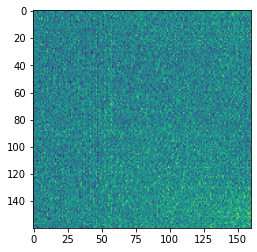

In [47]:
# the indices of getArrays()[x] are x=0  image, x=1  mask ,  x=2 variance 
donut = zernikeOutput.donutStampsExtra[17
                                      \]
plt.imshow(donut.stamp_im.getArrays()[0])

In [10]:
zerCoeff = zernikeOutput.outputZernikesAvg

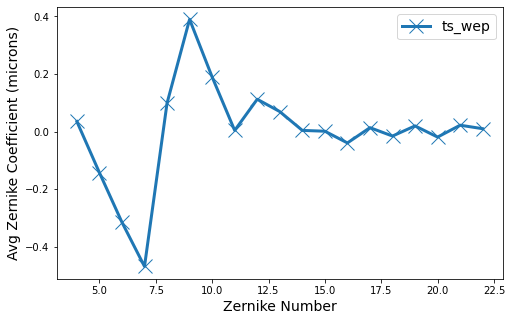

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8, 5))
# I'm not sure about the OPD values to compare to... 
#plt.plot(np.arange(4, 23), opdVals[85], '-o', lw=3, markersize=10, label='OPD')
plt.plot(np.arange(4, 23), zerCoeff, '-x', lw=3, markersize=14, label='ts_wep')
plt.xlabel('Zernike Number', size=14)
plt.ylabel('Avg Zernike Coefficient (microns)', size=14)
plt.legend(fontsize=14)